In [6]:
import torch
from torchmetrics.image.fid import FrechetInceptionDistance
import torchvision
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
import random

import warnings


def compute_fid_fn(inversion_targets, results):
    fid = FrechetInceptionDistance(normalize=True)
    fid.update(torch.cat([x[:100] for x in inversion_targets], dim=0).repeat(1, 1, 1, 2).cpu(), real=True)
    fid.update(torch.cat([x[:100] for x in results], dim=0).repeat(1, 1, 1, 2).cpu(), real=False)
    score = fid.compute()
    return score

def TV(x):
    batch_size = x.size()[0]
    h_x = x.size()[2]
    w_x = x.size()[3]
    count_h = _tensor_size(x[:, :, 1:, :])
    count_w = _tensor_size(x[:, :, :, 1:])
    h_tv = torch.pow(x[:, :, 1:, :] - x[:, :, :h_x - 1, :], 2).sum()
    w_tv = torch.pow(x[:, :, :, 1:] - x[:, :, :, :w_x - 1], 2).sum()
    return (h_tv / count_h + w_tv / count_w) / batch_size


def l2loss(x):
    return (x ** 2).mean()


def _tensor_size(t):
    return t.size()[1] * t.size()[2] * t.size()[3]


def get_examples_by_class(dataset, target, count=1):
    result = []
    for image, label in dataset:
        if label == target:
            result.append(image)
        if len(result) == count:
            break
    return torch.stack(result)


def normalize(result):
    min_v = result.flatten(1).min(dim=1).values.unsqueeze(-1)
    normalized = ((result.flatten(1) - min_v) /
                  (result.flatten(1).max(dim=1).values.unsqueeze(-1) - min_v))
    return normalized.reshape(result.shape)


def get_test_acc(client, server, testloader, device="cuda:0"):
    correct = 0
    total = 0
    client.eval()
    server.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            client_pred = client(images)
            pred = server(client_pred)
            _, predicted = torch.max(pred, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    client.train()
    server.train()
    return 100 * correct / total

def display_imagelist(images):
    if images[0].shape[0] > 1:
        print(f"Given set of {images[0].shape[0]} " +
                      "images for each class, displaying only " +
                      "the first ones for each class.")
    height, width = images[0].shape[-2:]
    fig, ax = plt.subplots(1, len(images))
    for index, image in enumerate(images):
        ax[index].axis('off')
        ax[index].imshow(image[0].cpu().detach().reshape(height, width))
    plt.show()

def display_cifar(images):
    _, ax = plt.subplots(1, len(images))
    for index, image in enumerate(images):
        img = torchvision.utils.make_grid(image)
        ax[index].axis('off')
        npimg = img.cpu().detach().numpy()
        ax[index].imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

def compute_metrics(inversion_targets, reconstructed_images,
                    reconstruction_losses, cut_layer_training_losses,
                    compute_fid=False):
    reconstruction_mse = np.mean(reconstruction_losses)
    cut_layer_mse = np.mean([loss_arr[-1] for loss_arr in cut_layer_training_losses])
    print(f"Recounstruction MSE: {reconstruction_mse:.3f}")
    print(f"Log10 of cut layer MSE: {np.log10(cut_layer_mse):.3f}")
    if compute_fid:
        print(f"FID: {compute_fid_fn(inversion_targets, reconstructed_images):.1f}")

In [7]:
import numpy as np
import torch
from torchvision import transforms, datasets

from tqdm.auto import tqdm

def model_inversion_stealing(clone_model, split_layer, target, input_size,
                            lambda_tv=0.1, lambda_l2=1, main_iters=1000, input_iters=100, model_iters=100, device='cuda:0'):
    x_pred = torch.empty(input_size, device=device).fill_(0.5).requires_grad_(True)
    target = target.to(device)
    clone_model = clone_model.to(device)
    input_opt = torch.optim.Adam([x_pred], lr=0.001, amsgrad=True)
    model_opt = torch.optim.Adam(clone_model.parameters(), lr=0.001, amsgrad=True)
    mse = torch.nn.MSELoss()
    loss_arr = []

    for main_iter in tqdm(range(main_iters)):
        for input_iter in range(input_iters):
            input_opt.zero_grad()
            pred = clone_model(x_pred)
            loss = mse(pred, target)
            loss_arr.append(loss.item())
            loss += lambda_tv*TV(x_pred) + lambda_l2*l2loss(x_pred)
            loss.backward()
            input_opt.step()
        for model_iter in range(model_iters):
            model_opt.zero_grad()
            pred = clone_model(x_pred)
            loss = mse(pred, target)
            loss.backward()
            model_opt.step()
            loss_arr.append(loss.item())

    return x_pred.detach(), loss_arr

In [8]:
from unsplit.models import MLPMixerClient, MLPMixerServer

In [9]:
device = torch.device("cuda:0")

In [10]:
dataset_name = "cifar10"
architecture = "mlp-mixer"
batch_size = 64

n_epochs = 300
cut_layer = 1

In [12]:
#uncomment this if autoaugment=True
#!git clone https://github.com/DeepVoltaire/AutoAugment.git

In [13]:
import sys
sys.path.append('./AutoAugment/')

from AutoAugment.autoaugment import CIFAR10Policy

def get_transform(autoaugment=False):
    padding=4
    size = 32
    mean, std = [0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616]
    
    train_transform_list = [transforms.RandomCrop(size=(size, size), padding=padding)]

    if autoaugment:
        train_transform_list.append(CIFAR10Policy())   
        

    train_transform = transforms.Compose(
        train_transform_list+[
            transforms.ToTensor(),
            transforms.Normalize(
                mean=mean,
                std = std
            )
        ]
    )
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean,
            std = std
        )
    ])

    return train_transform, test_transform

In [14]:
def create_models_and_data(dataset_name="mnist", architecture="mlp", batch_size=64, device="cuda:0", seed=0, cut_layer=1):
    assert dataset_name in ["mnist", "f_mnist", "cifar10"], "Wrong dataset name. Valid options are 'mnist', 'f_mnist' and 'cifar10'."
    assert architecture in ["mlp", "cnn", "mlp-mixer"], "Wrong architecture name. Valid options are 'mlp', 'cnn' and 'mlp-mixer'."
    dataset_creator = datasets.MNIST if dataset_name == "mnist" else datasets.FashionMNIST \
        if dataset_name == "f_mnist" else datasets.CIFAR10
    client_creator = MLPMixerClient
    server_creator = MLPMixerServer
    
    train_transform, test_transform = get_transform(autoaugment=True)

    trainset = dataset_creator(f'data/{dataset_name}', download=True, train=True, transform=train_transform)
    testset = dataset_creator(f'data/{dataset_name}', download=True, train=False, transform=test_transform)

    torch.manual_seed(seed)
    
    client, server = client_creator(cut_layer=cut_layer).to(device), server_creator(num_patches=(32 // 4) ** 2, cut_layer=cut_layer).to(device)
    return client, server, trainset, testset

In [15]:
client, server, trainset, testset = create_models_and_data(dataset_name=dataset_name,
                                                           architecture=architecture,
                                                           batch_size=batch_size,
                                                           device=device)

Files already downloaded and verified
Files already downloaded and verified


In [16]:
def cutmix_data(data, targets, alpha=1.0):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]
    
    lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    data[:, :, bbx1:bbx2, bby1:bby2] = shuffled_data[:, :, bbx1:bbx2, bby1:bby2]
    
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size(-1) * data.size(-2)))
    
    targets_a, targets_b = targets, shuffled_targets
    return data, targets_a, targets_b, lam

In [17]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [18]:
import warmup_scheduler

def train_client_server(client, server, trainset, testset, n_epochs=10, device="cuda:0", batch_size=128, eval_batch_size=1024, cutmix_prob=0.5, cutmix_beta=1.0):
    trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=batch_size)
    testloader = torch.utils.data.DataLoader(testset, shuffle=False, batch_size=eval_batch_size)

    client.to(device)
    server.to(device)

    client_opt = torch.optim.Adam(client.parameters(), lr=0.001, betas=(0.9, 0.99), weight_decay=5e-5)
    server_opt = torch.optim.Adam(server.parameters(), lr=0.001, betas=(0.9, 0.99), weight_decay=5e-5)
    
    base_client_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(client_opt, T_max=n_epochs, eta_min=1e-6)
    base_server_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(server_opt, T_max=n_epochs, eta_min=1e-6)
    
    client_scheduler = warmup_scheduler.GradualWarmupScheduler(client_opt, multiplier=1., total_epoch=5, after_scheduler=base_client_scheduler)
    server_scheduler = warmup_scheduler.GradualWarmupScheduler(server_opt, multiplier=1., total_epoch=5, after_scheduler=base_server_scheduler)    
    
    criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

    for epoch in range(n_epochs):
        running_loss = 0
        for images, labels in tqdm(trainloader):
            images, labels = images.to(device), labels.to(device)
            client_opt.zero_grad()
            server_opt.zero_grad()

            # Apply CutMix
            r = np.random.rand(1)
            if cutmix_beta > 0 and r < cutmix_prob:
                images, targets_a, targets_b, lam = cutmix_data(images, labels, cutmix_beta)
                client_pred = client(images)
                client_pred = client_pred.detach().requires_grad_()
                pred = server(client_pred)
                loss = criterion(pred, targets_a) * lam + criterion(pred, targets_b) * (1. - lam)
            else:
                client_pred = client(images)
                client_pred = client_pred.detach().requires_grad_()
                pred = server(client_pred)
                loss = criterion(pred, labels)

            running_loss += loss.item()

            loss.backward()
            server_opt.step()

            client_pred_grad = client_pred.grad
            client_pred.backward(client_pred_grad)
            client_opt.step()
            
        client_scheduler.step()
        server_scheduler.step()
            
        client_lr = client_scheduler.get_last_lr()[0]
        server_lr = server_scheduler.get_last_lr()[0]
            
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_acc(client, server, testloader, device)}% Client LR: {client_lr:.6e} Server LR: {server_lr:.6e}')
    
    return client, server


In [19]:
client, server = train_client_server(client=client, server=server, trainset=trainset, testset=testset,
                                     n_epochs=300, device="cuda:0")

100%|██████████| 391/391 [00:30<00:00, 12.80it/s]


Epoch: 0 Loss: 2.3097744786830816 Acc: 10.84% Client LR: 2.000000e-04 Server LR: 2.000000e-04


100%|██████████| 391/391 [00:30<00:00, 12.79it/s]


Epoch: 1 Loss: 2.1449261300094293 Acc: 39.11% Client LR: 4.000000e-04 Server LR: 4.000000e-04


100%|██████████| 391/391 [00:30<00:00, 12.75it/s]


Epoch: 2 Loss: 2.0262410146805943 Acc: 48.02% Client LR: 6.000000e-04 Server LR: 6.000000e-04


100%|██████████| 391/391 [00:30<00:00, 12.82it/s]


Epoch: 3 Loss: 1.9534952280771396 Acc: 51.43% Client LR: 8.000000e-04 Server LR: 8.000000e-04


100%|██████████| 391/391 [00:30<00:00, 12.88it/s]


Epoch: 4 Loss: 1.8710405283876697 Acc: 54.44% Client LR: 1.000000e-03 Server LR: 1.000000e-03


100%|██████████| 391/391 [00:30<00:00, 12.77it/s]


Epoch: 5 Loss: 1.866466789904153 Acc: 56.84% Client LR: 1.000000e-03 Server LR: 1.000000e-03


100%|██████████| 391/391 [00:30<00:00, 12.64it/s]


Epoch: 6 Loss: 1.8088175143732135 Acc: 58.12% Client LR: 9.999726e-04 Server LR: 9.999726e-04


100%|██████████| 391/391 [00:30<00:00, 12.75it/s]


Epoch: 7 Loss: 1.7574897647818641 Acc: 60.47% Client LR: 9.998905e-04 Server LR: 9.998905e-04


100%|██████████| 391/391 [00:30<00:00, 12.78it/s]


Epoch: 8 Loss: 1.7440420721497987 Acc: 63.92% Client LR: 9.997535e-04 Server LR: 9.997535e-04


100%|██████████| 391/391 [00:30<00:00, 12.78it/s]


Epoch: 9 Loss: 1.7224001375305684 Acc: 65.3% Client LR: 9.995619e-04 Server LR: 9.995619e-04


100%|██████████| 391/391 [00:30<00:00, 12.79it/s]


Epoch: 10 Loss: 1.7052173779138824 Acc: 66.36% Client LR: 9.993155e-04 Server LR: 9.993155e-04


100%|██████████| 391/391 [00:30<00:00, 12.87it/s]


Epoch: 11 Loss: 1.6821710267640135 Acc: 66.21% Client LR: 9.990144e-04 Server LR: 9.990144e-04


100%|██████████| 391/391 [00:30<00:00, 12.74it/s]


Epoch: 12 Loss: 1.6930328769147243 Acc: 67.43% Client LR: 9.986586e-04 Server LR: 9.986586e-04


100%|██████████| 391/391 [00:30<00:00, 12.74it/s]


Epoch: 13 Loss: 1.6616453548221637 Acc: 68.32% Client LR: 9.982482e-04 Server LR: 9.982482e-04


100%|██████████| 391/391 [00:30<00:00, 12.81it/s]


Epoch: 14 Loss: 1.6384234486333549 Acc: 69.67% Client LR: 9.977832e-04 Server LR: 9.977832e-04


100%|██████████| 391/391 [00:30<00:00, 12.72it/s]


Epoch: 15 Loss: 1.6228642384414478 Acc: 71.01% Client LR: 9.972637e-04 Server LR: 9.972637e-04


100%|██████████| 391/391 [00:30<00:00, 12.65it/s]


Epoch: 16 Loss: 1.6226729566178968 Acc: 70.91% Client LR: 9.966897e-04 Server LR: 9.966897e-04


100%|██████████| 391/391 [00:30<00:00, 12.63it/s]


Epoch: 17 Loss: 1.592372977825077 Acc: 70.58% Client LR: 9.960613e-04 Server LR: 9.960613e-04


100%|██████████| 391/391 [00:30<00:00, 12.80it/s]


Epoch: 18 Loss: 1.5618199302107476 Acc: 71.55% Client LR: 9.953785e-04 Server LR: 9.953785e-04


100%|██████████| 391/391 [00:30<00:00, 12.83it/s]


Epoch: 19 Loss: 1.603921054879113 Acc: 70.48% Client LR: 9.946415e-04 Server LR: 9.946415e-04


100%|██████████| 391/391 [00:30<00:00, 12.88it/s]


Epoch: 20 Loss: 1.5771934147685995 Acc: 72.53% Client LR: 9.938503e-04 Server LR: 9.938503e-04


100%|██████████| 391/391 [00:30<00:00, 12.76it/s]


Epoch: 21 Loss: 1.584381524254294 Acc: 72.93% Client LR: 9.930050e-04 Server LR: 9.930050e-04


100%|██████████| 391/391 [00:30<00:00, 12.73it/s]


Epoch: 22 Loss: 1.5705309069674949 Acc: 72.26% Client LR: 9.921057e-04 Server LR: 9.921057e-04


100%|██████████| 391/391 [00:31<00:00, 12.60it/s]


Epoch: 23 Loss: 1.522659319745915 Acc: 73.15% Client LR: 9.911525e-04 Server LR: 9.911525e-04


100%|██████████| 391/391 [00:30<00:00, 12.67it/s]


Epoch: 24 Loss: 1.5471696923760807 Acc: 74.57% Client LR: 9.901455e-04 Server LR: 9.901455e-04


100%|██████████| 391/391 [00:30<00:00, 12.72it/s]


Epoch: 25 Loss: 1.512683708344579 Acc: 73.54% Client LR: 9.890847e-04 Server LR: 9.890847e-04


100%|██████████| 391/391 [00:30<00:00, 12.69it/s]


Epoch: 26 Loss: 1.5191800685794763 Acc: 74.52% Client LR: 9.879704e-04 Server LR: 9.879704e-04


100%|██████████| 391/391 [00:30<00:00, 12.93it/s]


Epoch: 27 Loss: 1.5192547740838718 Acc: 73.99% Client LR: 9.868027e-04 Server LR: 9.868027e-04


100%|██████████| 391/391 [00:30<00:00, 12.75it/s]


Epoch: 28 Loss: 1.500797041236897 Acc: 74.4% Client LR: 9.855816e-04 Server LR: 9.855816e-04


100%|██████████| 391/391 [00:30<00:00, 12.77it/s]


Epoch: 29 Loss: 1.5056672824923034 Acc: 74.22% Client LR: 9.843073e-04 Server LR: 9.843073e-04


100%|██████████| 391/391 [00:30<00:00, 12.85it/s]


Epoch: 30 Loss: 1.4821507482577467 Acc: 74.72% Client LR: 9.829800e-04 Server LR: 9.829800e-04


100%|██████████| 391/391 [00:30<00:00, 12.76it/s]


Epoch: 31 Loss: 1.4555787857231277 Acc: 76.27% Client LR: 9.815997e-04 Server LR: 9.815997e-04


100%|██████████| 391/391 [00:30<00:00, 12.78it/s]


Epoch: 32 Loss: 1.5256254700443628 Acc: 76.21% Client LR: 9.801667e-04 Server LR: 9.801667e-04


100%|██████████| 391/391 [00:30<00:00, 12.77it/s]


Epoch: 33 Loss: 1.46564888009025 Acc: 76.77% Client LR: 9.786811e-04 Server LR: 9.786811e-04


100%|██████████| 391/391 [00:31<00:00, 12.59it/s]


Epoch: 34 Loss: 1.4764053833759045 Acc: 75.93% Client LR: 9.771430e-04 Server LR: 9.771430e-04


100%|██████████| 391/391 [00:30<00:00, 12.66it/s]


Epoch: 35 Loss: 1.489138146190692 Acc: 76.8% Client LR: 9.755527e-04 Server LR: 9.755527e-04


100%|██████████| 391/391 [00:30<00:00, 12.78it/s]


Epoch: 36 Loss: 1.4866515417842914 Acc: 76.12% Client LR: 9.739103e-04 Server LR: 9.739103e-04


100%|██████████| 391/391 [00:30<00:00, 12.86it/s]


Epoch: 37 Loss: 1.4552590947626802 Acc: 76.46% Client LR: 9.722160e-04 Server LR: 9.722160e-04


100%|██████████| 391/391 [00:30<00:00, 12.93it/s]


Epoch: 38 Loss: 1.4695232172146477 Acc: 77.73% Client LR: 9.704699e-04 Server LR: 9.704699e-04


100%|██████████| 391/391 [00:30<00:00, 12.71it/s]


Epoch: 39 Loss: 1.5040041049728003 Acc: 77.67% Client LR: 9.686724e-04 Server LR: 9.686724e-04


100%|██████████| 391/391 [00:30<00:00, 12.67it/s]


Epoch: 40 Loss: 1.4444199465119931 Acc: 77.7% Client LR: 9.668234e-04 Server LR: 9.668234e-04


100%|██████████| 391/391 [00:30<00:00, 12.77it/s]


Epoch: 41 Loss: 1.4382877084605223 Acc: 77.75% Client LR: 9.649234e-04 Server LR: 9.649234e-04


100%|██████████| 391/391 [00:31<00:00, 12.61it/s]


Epoch: 42 Loss: 1.4435528445121881 Acc: 78.09% Client LR: 9.629724e-04 Server LR: 9.629724e-04


100%|██████████| 391/391 [00:31<00:00, 12.58it/s]


Epoch: 43 Loss: 1.454081147680502 Acc: 78.16% Client LR: 9.609706e-04 Server LR: 9.609706e-04


100%|██████████| 391/391 [00:31<00:00, 12.54it/s]


Epoch: 44 Loss: 1.444202148396036 Acc: 77.56% Client LR: 9.589184e-04 Server LR: 9.589184e-04


100%|██████████| 391/391 [00:31<00:00, 12.60it/s]


Epoch: 45 Loss: 1.3983756430313716 Acc: 78.59% Client LR: 9.568160e-04 Server LR: 9.568160e-04


100%|██████████| 391/391 [00:30<00:00, 12.64it/s]


Epoch: 46 Loss: 1.399694242135948 Acc: 77.65% Client LR: 9.546634e-04 Server LR: 9.546634e-04


100%|██████████| 391/391 [00:30<00:00, 12.66it/s]


Epoch: 47 Loss: 1.4178894099677006 Acc: 78.05% Client LR: 9.524611e-04 Server LR: 9.524611e-04


100%|██████████| 391/391 [00:31<00:00, 12.55it/s]


Epoch: 48 Loss: 1.4179597557963008 Acc: 78.37% Client LR: 9.502092e-04 Server LR: 9.502092e-04


100%|██████████| 391/391 [00:30<00:00, 12.64it/s]


Epoch: 49 Loss: 1.430089241708331 Acc: 78.02% Client LR: 9.479080e-04 Server LR: 9.479080e-04


100%|██████████| 391/391 [00:30<00:00, 12.65it/s]


Epoch: 50 Loss: 1.4221346341740444 Acc: 78.8% Client LR: 9.455578e-04 Server LR: 9.455578e-04


100%|██████████| 391/391 [00:31<00:00, 12.51it/s]


Epoch: 51 Loss: 1.4021919355977832 Acc: 79.67% Client LR: 9.431587e-04 Server LR: 9.431587e-04


100%|██████████| 391/391 [00:31<00:00, 12.59it/s]


Epoch: 52 Loss: 1.4057118506992565 Acc: 79.74% Client LR: 9.407111e-04 Server LR: 9.407111e-04


100%|██████████| 391/391 [00:31<00:00, 12.61it/s]


Epoch: 53 Loss: 1.420505570023871 Acc: 80.69% Client LR: 9.382152e-04 Server LR: 9.382152e-04


100%|██████████| 391/391 [00:30<00:00, 12.72it/s]


Epoch: 54 Loss: 1.426217060869612 Acc: 79.49% Client LR: 9.356713e-04 Server LR: 9.356713e-04


100%|██████████| 391/391 [00:30<00:00, 12.85it/s]


Epoch: 55 Loss: 1.3749505100042925 Acc: 79.93% Client LR: 9.330797e-04 Server LR: 9.330797e-04


100%|██████████| 391/391 [00:30<00:00, 12.87it/s]


Epoch: 56 Loss: 1.3717280336658058 Acc: 80.08% Client LR: 9.304406e-04 Server LR: 9.304406e-04


100%|██████████| 391/391 [00:30<00:00, 12.76it/s]


Epoch: 57 Loss: 1.390750319146744 Acc: 80.07% Client LR: 9.277544e-04 Server LR: 9.277544e-04


100%|██████████| 391/391 [00:30<00:00, 12.86it/s]


Epoch: 58 Loss: 1.3688610025379053 Acc: 79.6% Client LR: 9.250214e-04 Server LR: 9.250214e-04


100%|██████████| 391/391 [00:31<00:00, 12.60it/s]


Epoch: 59 Loss: 1.355757983749175 Acc: 80.7% Client LR: 9.222418e-04 Server LR: 9.222418e-04


100%|██████████| 391/391 [00:30<00:00, 12.72it/s]


Epoch: 60 Loss: 1.373361662830538 Acc: 81.19% Client LR: 9.194159e-04 Server LR: 9.194159e-04


100%|██████████| 391/391 [00:30<00:00, 12.71it/s]


Epoch: 61 Loss: 1.345812217963626 Acc: 81.18% Client LR: 9.165442e-04 Server LR: 9.165442e-04


100%|██████████| 391/391 [00:30<00:00, 12.78it/s]


Epoch: 62 Loss: 1.3501965961492886 Acc: 81.55% Client LR: 9.136267e-04 Server LR: 9.136267e-04


100%|██████████| 391/391 [00:30<00:00, 12.81it/s]


Epoch: 63 Loss: 1.371875458971009 Acc: 81.63% Client LR: 9.106640e-04 Server LR: 9.106640e-04


100%|██████████| 391/391 [00:30<00:00, 12.88it/s]


Epoch: 64 Loss: 1.3685486118506898 Acc: 81.65% Client LR: 9.076563e-04 Server LR: 9.076563e-04


100%|██████████| 391/391 [00:30<00:00, 12.83it/s]


Epoch: 65 Loss: 1.3866514859297085 Acc: 81.38% Client LR: 9.046040e-04 Server LR: 9.046040e-04


100%|██████████| 391/391 [00:30<00:00, 12.92it/s]


Epoch: 66 Loss: 1.350805618726384 Acc: 81.18% Client LR: 9.015073e-04 Server LR: 9.015073e-04


100%|██████████| 391/391 [00:30<00:00, 12.89it/s]


Epoch: 67 Loss: 1.384242858575738 Acc: 81.1% Client LR: 8.983667e-04 Server LR: 8.983667e-04


100%|██████████| 391/391 [00:30<00:00, 12.86it/s]


Epoch: 68 Loss: 1.347303841120142 Acc: 82.21% Client LR: 8.951824e-04 Server LR: 8.951824e-04


100%|██████████| 391/391 [00:30<00:00, 12.82it/s]


Epoch: 69 Loss: 1.3592405028050514 Acc: 81.26% Client LR: 8.919549e-04 Server LR: 8.919549e-04


100%|██████████| 391/391 [00:30<00:00, 12.92it/s]


Epoch: 70 Loss: 1.3662258560395302 Acc: 81.71% Client LR: 8.886844e-04 Server LR: 8.886844e-04


100%|██████████| 391/391 [00:30<00:00, 12.81it/s]


Epoch: 71 Loss: 1.3463612746094804 Acc: 80.34% Client LR: 8.853714e-04 Server LR: 8.853714e-04


100%|██████████| 391/391 [00:30<00:00, 12.75it/s]


Epoch: 72 Loss: 1.3581254392328774 Acc: 82.18% Client LR: 8.820161e-04 Server LR: 8.820161e-04


100%|██████████| 391/391 [00:30<00:00, 12.85it/s]


Epoch: 73 Loss: 1.3260454831220914 Acc: 82.11% Client LR: 8.786190e-04 Server LR: 8.786190e-04


100%|██████████| 391/391 [00:30<00:00, 12.85it/s]


Epoch: 74 Loss: 1.3388766649434023 Acc: 81.36% Client LR: 8.751805e-04 Server LR: 8.751805e-04


100%|██████████| 391/391 [00:30<00:00, 12.68it/s]


Epoch: 75 Loss: 1.3250260252476957 Acc: 82.83% Client LR: 8.717008e-04 Server LR: 8.717008e-04


100%|██████████| 391/391 [00:30<00:00, 12.72it/s]


Epoch: 76 Loss: 1.3133562227039386 Acc: 82.69% Client LR: 8.681805e-04 Server LR: 8.681805e-04


100%|██████████| 391/391 [00:30<00:00, 12.63it/s]


Epoch: 77 Loss: 1.3172694074223414 Acc: 82.54% Client LR: 8.646198e-04 Server LR: 8.646198e-04


100%|██████████| 391/391 [00:31<00:00, 12.58it/s]


Epoch: 78 Loss: 1.3194213390655225 Acc: 82.58% Client LR: 8.610192e-04 Server LR: 8.610192e-04


100%|██████████| 391/391 [00:31<00:00, 12.56it/s]


Epoch: 79 Loss: 1.3224176141002295 Acc: 82.62% Client LR: 8.573791e-04 Server LR: 8.573791e-04


100%|██████████| 391/391 [00:30<00:00, 12.70it/s]


Epoch: 80 Loss: 1.3076348951100694 Acc: 83.6% Client LR: 8.536998e-04 Server LR: 8.536998e-04


100%|██████████| 391/391 [00:30<00:00, 12.93it/s]


Epoch: 81 Loss: 1.3326467117080298 Acc: 82.64% Client LR: 8.499818e-04 Server LR: 8.499818e-04


100%|██████████| 391/391 [00:30<00:00, 12.95it/s]


Epoch: 82 Loss: 1.3057880610456247 Acc: 82.99% Client LR: 8.462255e-04 Server LR: 8.462255e-04


100%|██████████| 391/391 [00:30<00:00, 12.82it/s]


Epoch: 83 Loss: 1.3365333761705462 Acc: 82.61% Client LR: 8.424313e-04 Server LR: 8.424313e-04


100%|██████████| 391/391 [00:30<00:00, 12.89it/s]


Epoch: 84 Loss: 1.358663653778603 Acc: 83.05% Client LR: 8.385995e-04 Server LR: 8.385995e-04


100%|██████████| 391/391 [00:30<00:00, 12.84it/s]


Epoch: 85 Loss: 1.3381029057990559 Acc: 83.15% Client LR: 8.347307e-04 Server LR: 8.347307e-04


100%|██████████| 391/391 [00:30<00:00, 12.84it/s]


Epoch: 86 Loss: 1.312242438421225 Acc: 83.47% Client LR: 8.308253e-04 Server LR: 8.308253e-04


100%|██████████| 391/391 [00:30<00:00, 12.80it/s]


Epoch: 87 Loss: 1.2993413921817185 Acc: 83.57% Client LR: 8.268836e-04 Server LR: 8.268836e-04


100%|██████████| 391/391 [00:30<00:00, 12.77it/s]


Epoch: 88 Loss: 1.313448272702639 Acc: 82.18% Client LR: 8.229061e-04 Server LR: 8.229061e-04


100%|██████████| 391/391 [00:30<00:00, 12.71it/s]


Epoch: 89 Loss: 1.2900435354398645 Acc: 82.66% Client LR: 8.188933e-04 Server LR: 8.188933e-04


100%|██████████| 391/391 [00:30<00:00, 12.86it/s]


Epoch: 90 Loss: 1.308298719051244 Acc: 83.22% Client LR: 8.148455e-04 Server LR: 8.148455e-04


100%|██████████| 391/391 [00:30<00:00, 12.89it/s]


Epoch: 91 Loss: 1.282422082350992 Acc: 82.02% Client LR: 8.107633e-04 Server LR: 8.107633e-04


100%|██████████| 391/391 [00:30<00:00, 12.79it/s]


Epoch: 92 Loss: 1.2965789640041263 Acc: 83.09% Client LR: 8.066471e-04 Server LR: 8.066471e-04


100%|██████████| 391/391 [00:30<00:00, 12.83it/s]


Epoch: 93 Loss: 1.295903076753592 Acc: 83.8% Client LR: 8.024973e-04 Server LR: 8.024973e-04


100%|██████████| 391/391 [00:30<00:00, 12.83it/s]


Epoch: 94 Loss: 1.2810848663225198 Acc: 82.5% Client LR: 7.983143e-04 Server LR: 7.983143e-04


100%|██████████| 391/391 [00:30<00:00, 12.67it/s]


Epoch: 95 Loss: 1.27041737197915 Acc: 83.69% Client LR: 7.940987e-04 Server LR: 7.940987e-04


100%|██████████| 391/391 [00:30<00:00, 12.77it/s]


Epoch: 96 Loss: 1.305838541606503 Acc: 83.73% Client LR: 7.898509e-04 Server LR: 7.898509e-04


100%|██████████| 391/391 [00:30<00:00, 12.84it/s]


Epoch: 97 Loss: 1.2665367640192857 Acc: 83.83% Client LR: 7.855714e-04 Server LR: 7.855714e-04


100%|██████████| 391/391 [00:30<00:00, 12.76it/s]


Epoch: 98 Loss: 1.2803947978922168 Acc: 83.48% Client LR: 7.812606e-04 Server LR: 7.812606e-04


100%|██████████| 391/391 [00:30<00:00, 12.79it/s]


Epoch: 99 Loss: 1.3054576726520764 Acc: 83.49% Client LR: 7.769191e-04 Server LR: 7.769191e-04


100%|██████████| 391/391 [00:30<00:00, 12.83it/s]


Epoch: 100 Loss: 1.281007441718255 Acc: 85.03% Client LR: 7.725472e-04 Server LR: 7.725472e-04


100%|██████████| 391/391 [00:30<00:00, 12.93it/s]


Epoch: 101 Loss: 1.2935578798698952 Acc: 84.27% Client LR: 7.681455e-04 Server LR: 7.681455e-04


100%|██████████| 391/391 [00:30<00:00, 12.88it/s]


Epoch: 102 Loss: 1.273017468354891 Acc: 84.23% Client LR: 7.637144e-04 Server LR: 7.637144e-04


100%|██████████| 391/391 [00:30<00:00, 12.92it/s]


Epoch: 103 Loss: 1.280556688070907 Acc: 84.92% Client LR: 7.592545e-04 Server LR: 7.592545e-04


100%|██████████| 391/391 [00:30<00:00, 12.85it/s]


Epoch: 104 Loss: 1.2663387009859695 Acc: 83.82% Client LR: 7.547662e-04 Server LR: 7.547662e-04


100%|██████████| 391/391 [00:30<00:00, 12.79it/s]


Epoch: 105 Loss: 1.2964621366137434 Acc: 84.37% Client LR: 7.502500e-04 Server LR: 7.502500e-04


100%|██████████| 391/391 [00:30<00:00, 12.84it/s]


Epoch: 106 Loss: 1.2876976815331014 Acc: 84.73% Client LR: 7.457064e-04 Server LR: 7.457064e-04


100%|██████████| 391/391 [00:30<00:00, 12.76it/s]


Epoch: 107 Loss: 1.2799614876737375 Acc: 84.18% Client LR: 7.411360e-04 Server LR: 7.411360e-04


100%|██████████| 391/391 [00:30<00:00, 12.77it/s]


Epoch: 108 Loss: 1.2615356800501303 Acc: 83.94% Client LR: 7.365391e-04 Server LR: 7.365391e-04


100%|██████████| 391/391 [00:30<00:00, 12.80it/s]


Epoch: 109 Loss: 1.2711018104382488 Acc: 84.24% Client LR: 7.319164e-04 Server LR: 7.319164e-04


100%|██████████| 391/391 [00:30<00:00, 12.96it/s]


Epoch: 110 Loss: 1.260909060992853 Acc: 84.37% Client LR: 7.272683e-04 Server LR: 7.272683e-04


100%|██████████| 391/391 [00:30<00:00, 12.83it/s]


Epoch: 111 Loss: 1.2715866117526198 Acc: 84.58% Client LR: 7.225953e-04 Server LR: 7.225953e-04


100%|██████████| 391/391 [00:30<00:00, 12.86it/s]


Epoch: 112 Loss: 1.208793880841921 Acc: 84.52% Client LR: 7.178979e-04 Server LR: 7.178979e-04


100%|██████████| 391/391 [00:30<00:00, 12.76it/s]


Epoch: 113 Loss: 1.2448810695687218 Acc: 84.94% Client LR: 7.131768e-04 Server LR: 7.131768e-04


100%|██████████| 391/391 [00:30<00:00, 12.69it/s]


Epoch: 114 Loss: 1.254120770012936 Acc: 84.95% Client LR: 7.084323e-04 Server LR: 7.084323e-04


100%|██████████| 391/391 [00:30<00:00, 12.65it/s]


Epoch: 115 Loss: 1.2995986284502328 Acc: 85.09% Client LR: 7.036650e-04 Server LR: 7.036650e-04


100%|██████████| 391/391 [00:30<00:00, 12.65it/s]


Epoch: 116 Loss: 1.2353611344571613 Acc: 84.27% Client LR: 6.988754e-04 Server LR: 6.988754e-04


100%|██████████| 391/391 [00:30<00:00, 12.68it/s]


Epoch: 117 Loss: 1.2976160046389646 Acc: 84.47% Client LR: 6.940640e-04 Server LR: 6.940640e-04


100%|██████████| 391/391 [00:30<00:00, 12.69it/s]


Epoch: 118 Loss: 1.258826887668551 Acc: 84.65% Client LR: 6.892315e-04 Server LR: 6.892315e-04


100%|██████████| 391/391 [00:30<00:00, 12.64it/s]


Epoch: 119 Loss: 1.2452124691070499 Acc: 84.43% Client LR: 6.843782e-04 Server LR: 6.843782e-04


100%|██████████| 391/391 [00:30<00:00, 12.62it/s]


Epoch: 120 Loss: 1.2467240607342147 Acc: 84.38% Client LR: 6.795048e-04 Server LR: 6.795048e-04


100%|██████████| 391/391 [00:30<00:00, 12.69it/s]


Epoch: 121 Loss: 1.2211613845642266 Acc: 84.44% Client LR: 6.746117e-04 Server LR: 6.746117e-04


100%|██████████| 391/391 [00:31<00:00, 12.57it/s]


Epoch: 122 Loss: 1.2315355325903734 Acc: 84.94% Client LR: 6.696996e-04 Server LR: 6.696996e-04


100%|██████████| 391/391 [00:31<00:00, 12.60it/s]


Epoch: 123 Loss: 1.2627491944891107 Acc: 84.7% Client LR: 6.647689e-04 Server LR: 6.647689e-04


100%|██████████| 391/391 [00:31<00:00, 12.59it/s]


Epoch: 124 Loss: 1.2146102090930695 Acc: 84.94% Client LR: 6.598202e-04 Server LR: 6.598202e-04


100%|██████████| 391/391 [00:30<00:00, 12.67it/s]


Epoch: 125 Loss: 1.2184490498984257 Acc: 85.39% Client LR: 6.548540e-04 Server LR: 6.548540e-04


100%|██████████| 391/391 [00:30<00:00, 12.75it/s]


Epoch: 126 Loss: 1.2553331423598482 Acc: 85.1% Client LR: 6.498709e-04 Server LR: 6.498709e-04


100%|██████████| 391/391 [00:30<00:00, 12.85it/s]


Epoch: 127 Loss: 1.2489301978474687 Acc: 85.57% Client LR: 6.448714e-04 Server LR: 6.448714e-04


100%|██████████| 391/391 [00:30<00:00, 12.87it/s]


Epoch: 128 Loss: 1.2502795642294238 Acc: 85.01% Client LR: 6.398561e-04 Server LR: 6.398561e-04


100%|██████████| 391/391 [00:30<00:00, 12.90it/s]


Epoch: 129 Loss: 1.219104177659125 Acc: 85.12% Client LR: 6.348255e-04 Server LR: 6.348255e-04


100%|██████████| 391/391 [00:30<00:00, 12.84it/s]


Epoch: 130 Loss: 1.2674695753380465 Acc: 84.91% Client LR: 6.297801e-04 Server LR: 6.297801e-04


100%|██████████| 391/391 [00:30<00:00, 12.72it/s]


Epoch: 131 Loss: 1.2085909001967485 Acc: 84.58% Client LR: 6.247206e-04 Server LR: 6.247206e-04


100%|██████████| 391/391 [00:30<00:00, 12.80it/s]


Epoch: 132 Loss: 1.2182192104246916 Acc: 85.56% Client LR: 6.196475e-04 Server LR: 6.196475e-04


100%|██████████| 391/391 [00:30<00:00, 12.71it/s]


Epoch: 133 Loss: 1.251118024444336 Acc: 85.52% Client LR: 6.145613e-04 Server LR: 6.145613e-04


100%|██████████| 391/391 [00:30<00:00, 12.74it/s]


Epoch: 134 Loss: 1.2543038274625988 Acc: 85.11% Client LR: 6.094625e-04 Server LR: 6.094625e-04


100%|██████████| 391/391 [00:30<00:00, 12.89it/s]


Epoch: 135 Loss: 1.1813348400623291 Acc: 85.45% Client LR: 6.043519e-04 Server LR: 6.043519e-04


100%|██████████| 391/391 [00:30<00:00, 12.79it/s]


Epoch: 136 Loss: 1.1920927365112792 Acc: 85.83% Client LR: 5.992298e-04 Server LR: 5.992298e-04


100%|██████████| 391/391 [00:30<00:00, 12.89it/s]


Epoch: 137 Loss: 1.2171043427399053 Acc: 85.74% Client LR: 5.940970e-04 Server LR: 5.940970e-04


100%|██████████| 391/391 [00:30<00:00, 12.88it/s]


Epoch: 138 Loss: 1.2348257182809093 Acc: 86.3% Client LR: 5.889538e-04 Server LR: 5.889538e-04


100%|██████████| 391/391 [00:30<00:00, 12.90it/s]


Epoch: 139 Loss: 1.2321081498394841 Acc: 86.46% Client LR: 5.838010e-04 Server LR: 5.838010e-04


100%|██████████| 391/391 [00:30<00:00, 12.66it/s]


Epoch: 140 Loss: 1.2446896156386646 Acc: 85.83% Client LR: 5.786390e-04 Server LR: 5.786390e-04


100%|██████████| 391/391 [00:30<00:00, 12.81it/s]


Epoch: 141 Loss: 1.2224117573874687 Acc: 86.16% Client LR: 5.734685e-04 Server LR: 5.734685e-04


100%|██████████| 391/391 [00:30<00:00, 12.79it/s]


Epoch: 142 Loss: 1.1844549714146977 Acc: 86.22% Client LR: 5.682899e-04 Server LR: 5.682899e-04


100%|██████████| 391/391 [00:30<00:00, 12.89it/s]


Epoch: 143 Loss: 1.2277632210870533 Acc: 85.94% Client LR: 5.631040e-04 Server LR: 5.631040e-04


100%|██████████| 391/391 [00:30<00:00, 12.81it/s]


Epoch: 144 Loss: 1.196988674380895 Acc: 85.68% Client LR: 5.579111e-04 Server LR: 5.579111e-04


100%|██████████| 391/391 [00:30<00:00, 12.77it/s]


Epoch: 145 Loss: 1.2325925516045613 Acc: 85.85% Client LR: 5.527120e-04 Server LR: 5.527120e-04


100%|██████████| 391/391 [00:30<00:00, 12.87it/s]


Epoch: 146 Loss: 1.2311178272032677 Acc: 85.94% Client LR: 5.475071e-04 Server LR: 5.475071e-04


100%|██████████| 391/391 [00:30<00:00, 12.93it/s]


Epoch: 147 Loss: 1.1886434689202272 Acc: 86.66% Client LR: 5.422971e-04 Server LR: 5.422971e-04


100%|██████████| 391/391 [00:30<00:00, 12.94it/s]


Epoch: 148 Loss: 1.2030779650754027 Acc: 86.47% Client LR: 5.370825e-04 Server LR: 5.370825e-04


100%|██████████| 391/391 [00:30<00:00, 12.75it/s]


Epoch: 149 Loss: 1.2125740173222768 Acc: 85.77% Client LR: 5.318639e-04 Server LR: 5.318639e-04


100%|██████████| 391/391 [00:30<00:00, 12.77it/s]


Epoch: 150 Loss: 1.1862466313954814 Acc: 86.41% Client LR: 5.266418e-04 Server LR: 5.266418e-04


100%|██████████| 391/391 [00:30<00:00, 12.78it/s]


Epoch: 151 Loss: 1.193886087526141 Acc: 85.29% Client LR: 5.214169e-04 Server LR: 5.214169e-04


100%|██████████| 391/391 [00:30<00:00, 12.76it/s]


Epoch: 152 Loss: 1.2250115412580387 Acc: 86.19% Client LR: 5.161897e-04 Server LR: 5.161897e-04


100%|██████████| 391/391 [00:30<00:00, 12.80it/s]


Epoch: 153 Loss: 1.1988104141276816 Acc: 86.41% Client LR: 5.109607e-04 Server LR: 5.109607e-04


100%|██████████| 391/391 [00:30<00:00, 12.86it/s]


Epoch: 154 Loss: 1.210803340920402 Acc: 86.24% Client LR: 5.057307e-04 Server LR: 5.057307e-04


100%|██████████| 391/391 [00:30<00:00, 12.81it/s]


Epoch: 155 Loss: 1.179298008799248 Acc: 86.2% Client LR: 5.005000e-04 Server LR: 5.005000e-04


100%|██████████| 391/391 [00:30<00:00, 12.85it/s]


Epoch: 156 Loss: 1.241160330412638 Acc: 86.61% Client LR: 4.952693e-04 Server LR: 4.952693e-04


100%|██████████| 391/391 [00:30<00:00, 12.72it/s]


Epoch: 157 Loss: 1.1746418024877758 Acc: 86.22% Client LR: 4.900393e-04 Server LR: 4.900393e-04


100%|██████████| 391/391 [00:30<00:00, 12.73it/s]


Epoch: 158 Loss: 1.1995261529522478 Acc: 86.41% Client LR: 4.848103e-04 Server LR: 4.848103e-04


100%|██████████| 391/391 [00:30<00:00, 12.74it/s]


Epoch: 159 Loss: 1.1903550731556496 Acc: 86.5% Client LR: 4.795831e-04 Server LR: 4.795831e-04


100%|██████████| 391/391 [00:31<00:00, 12.61it/s]


Epoch: 160 Loss: 1.1758069328944702 Acc: 86.26% Client LR: 4.743582e-04 Server LR: 4.743582e-04


100%|██████████| 391/391 [00:30<00:00, 12.68it/s]


Epoch: 161 Loss: 1.1824489304476686 Acc: 86.5% Client LR: 4.691361e-04 Server LR: 4.691361e-04


100%|██████████| 391/391 [00:30<00:00, 12.73it/s]


Epoch: 162 Loss: 1.1890533638122442 Acc: 86.88% Client LR: 4.639175e-04 Server LR: 4.639175e-04


100%|██████████| 391/391 [00:30<00:00, 12.72it/s]


Epoch: 163 Loss: 1.1904836152215748 Acc: 86.64% Client LR: 4.587029e-04 Server LR: 4.587029e-04


100%|██████████| 391/391 [00:30<00:00, 12.82it/s]


Epoch: 164 Loss: 1.1885618142154821 Acc: 86.7% Client LR: 4.534929e-04 Server LR: 4.534929e-04


100%|██████████| 391/391 [00:30<00:00, 12.86it/s]


Epoch: 165 Loss: 1.203919994404249 Acc: 86.31% Client LR: 4.482880e-04 Server LR: 4.482880e-04


100%|██████████| 391/391 [00:30<00:00, 12.82it/s]


Epoch: 166 Loss: 1.179617588629808 Acc: 86.37% Client LR: 4.430889e-04 Server LR: 4.430889e-04


100%|██████████| 391/391 [00:30<00:00, 12.75it/s]


Epoch: 167 Loss: 1.1929608694732647 Acc: 86.78% Client LR: 4.378960e-04 Server LR: 4.378960e-04


100%|██████████| 391/391 [00:30<00:00, 12.68it/s]


Epoch: 168 Loss: 1.185436862204081 Acc: 87.18% Client LR: 4.327101e-04 Server LR: 4.327101e-04


100%|██████████| 391/391 [00:31<00:00, 12.61it/s]


Epoch: 169 Loss: 1.1777243940421687 Acc: 86.98% Client LR: 4.275315e-04 Server LR: 4.275315e-04


100%|██████████| 391/391 [00:30<00:00, 12.68it/s]


Epoch: 170 Loss: 1.1865056417787168 Acc: 86.77% Client LR: 4.223610e-04 Server LR: 4.223610e-04


100%|██████████| 391/391 [00:30<00:00, 12.76it/s]


Epoch: 171 Loss: 1.1539367745294595 Acc: 86.88% Client LR: 4.171990e-04 Server LR: 4.171990e-04


100%|██████████| 391/391 [00:30<00:00, 12.76it/s]


Epoch: 172 Loss: 1.1677212123675724 Acc: 87.03% Client LR: 4.120462e-04 Server LR: 4.120462e-04


100%|██████████| 391/391 [00:30<00:00, 12.84it/s]


Epoch: 173 Loss: 1.1781831270898395 Acc: 86.7% Client LR: 4.069030e-04 Server LR: 4.069030e-04


100%|██████████| 391/391 [00:30<00:00, 12.82it/s]


Epoch: 174 Loss: 1.1594313085841401 Acc: 87.31% Client LR: 4.017702e-04 Server LR: 4.017702e-04


100%|██████████| 391/391 [00:30<00:00, 12.83it/s]


Epoch: 175 Loss: 1.2131517745954605 Acc: 86.52% Client LR: 3.966481e-04 Server LR: 3.966481e-04


100%|██████████| 391/391 [00:30<00:00, 12.81it/s]


Epoch: 176 Loss: 1.1226528402789475 Acc: 86.89% Client LR: 3.915375e-04 Server LR: 3.915375e-04


100%|██████████| 391/391 [00:30<00:00, 12.63it/s]


Epoch: 177 Loss: 1.1535984742671936 Acc: 86.86% Client LR: 3.864387e-04 Server LR: 3.864387e-04


100%|██████████| 391/391 [00:30<00:00, 12.61it/s]


Epoch: 178 Loss: 1.1369743810590272 Acc: 87.43% Client LR: 3.813525e-04 Server LR: 3.813525e-04


100%|██████████| 391/391 [00:30<00:00, 12.82it/s]


Epoch: 179 Loss: 1.1769886419291387 Acc: 86.91% Client LR: 3.762794e-04 Server LR: 3.762794e-04


100%|██████████| 391/391 [00:30<00:00, 12.82it/s]


Epoch: 180 Loss: 1.1628182923702328 Acc: 87.36% Client LR: 3.712199e-04 Server LR: 3.712199e-04


100%|██████████| 391/391 [00:30<00:00, 12.92it/s]


Epoch: 181 Loss: 1.1681968005721832 Acc: 87.39% Client LR: 3.661745e-04 Server LR: 3.661745e-04


100%|██████████| 391/391 [00:30<00:00, 12.96it/s]


Epoch: 182 Loss: 1.175000566503276 Acc: 86.92% Client LR: 3.611439e-04 Server LR: 3.611439e-04


100%|██████████| 391/391 [00:30<00:00, 12.82it/s]


Epoch: 183 Loss: 1.1431354000745222 Acc: 87.17% Client LR: 3.561286e-04 Server LR: 3.561286e-04


100%|██████████| 391/391 [00:30<00:00, 12.80it/s]


Epoch: 184 Loss: 1.1743722073257428 Acc: 87.55% Client LR: 3.511291e-04 Server LR: 3.511291e-04


100%|██████████| 391/391 [00:30<00:00, 12.70it/s]


Epoch: 185 Loss: 1.1042691853345203 Acc: 87.14% Client LR: 3.461460e-04 Server LR: 3.461460e-04


100%|██████████| 391/391 [00:30<00:00, 12.76it/s]


Epoch: 186 Loss: 1.1535954333632195 Acc: 87.41% Client LR: 3.411798e-04 Server LR: 3.411798e-04


100%|██████████| 391/391 [00:30<00:00, 12.74it/s]


Epoch: 187 Loss: 1.148078611439756 Acc: 87.71% Client LR: 3.362311e-04 Server LR: 3.362311e-04


100%|██████████| 391/391 [00:30<00:00, 12.74it/s]


Epoch: 188 Loss: 1.1741496515091119 Acc: 87.9% Client LR: 3.313004e-04 Server LR: 3.313004e-04


100%|██████████| 391/391 [00:30<00:00, 12.76it/s]


Epoch: 189 Loss: 1.157435622056732 Acc: 87.84% Client LR: 3.263883e-04 Server LR: 3.263883e-04


100%|██████████| 391/391 [00:30<00:00, 12.83it/s]


Epoch: 190 Loss: 1.1167963967298913 Acc: 87.43% Client LR: 3.214952e-04 Server LR: 3.214952e-04


100%|██████████| 391/391 [00:30<00:00, 12.74it/s]


Epoch: 191 Loss: 1.1262009140780516 Acc: 87.79% Client LR: 3.166218e-04 Server LR: 3.166218e-04


100%|██████████| 391/391 [00:30<00:00, 12.76it/s]


Epoch: 192 Loss: 1.1752863437928203 Acc: 87.71% Client LR: 3.117685e-04 Server LR: 3.117685e-04


100%|██████████| 391/391 [00:30<00:00, 12.82it/s]


Epoch: 193 Loss: 1.1424024538006015 Acc: 87.71% Client LR: 3.069360e-04 Server LR: 3.069360e-04


100%|██████████| 391/391 [00:30<00:00, 12.77it/s]


Epoch: 194 Loss: 1.1309498542410028 Acc: 87.77% Client LR: 3.021246e-04 Server LR: 3.021246e-04


100%|██████████| 391/391 [00:30<00:00, 12.69it/s]


Epoch: 195 Loss: 1.0907600424478732 Acc: 87.44% Client LR: 2.973350e-04 Server LR: 2.973350e-04


100%|██████████| 391/391 [00:30<00:00, 12.64it/s]


Epoch: 196 Loss: 1.1483965956646462 Acc: 87.47% Client LR: 2.925677e-04 Server LR: 2.925677e-04


100%|██████████| 391/391 [00:30<00:00, 12.73it/s]


Epoch: 197 Loss: 1.1895439431185613 Acc: 87.54% Client LR: 2.878232e-04 Server LR: 2.878232e-04


100%|██████████| 391/391 [00:30<00:00, 12.68it/s]


Epoch: 198 Loss: 1.1338108133172136 Acc: 87.77% Client LR: 2.831021e-04 Server LR: 2.831021e-04


100%|██████████| 391/391 [00:30<00:00, 12.75it/s]


Epoch: 199 Loss: 1.136491043488388 Acc: 87.67% Client LR: 2.784047e-04 Server LR: 2.784047e-04


100%|██████████| 391/391 [00:30<00:00, 12.66it/s]


Epoch: 200 Loss: 1.1219111728241375 Acc: 87.56% Client LR: 2.737317e-04 Server LR: 2.737317e-04


100%|██████████| 391/391 [00:30<00:00, 12.81it/s]


Epoch: 201 Loss: 1.118510347345601 Acc: 87.75% Client LR: 2.690836e-04 Server LR: 2.690836e-04


100%|██████████| 391/391 [00:30<00:00, 12.79it/s]


Epoch: 202 Loss: 1.111427360026123 Acc: 87.91% Client LR: 2.644609e-04 Server LR: 2.644609e-04


100%|██████████| 391/391 [00:30<00:00, 12.75it/s]


Epoch: 203 Loss: 1.152422201602965 Acc: 88.28% Client LR: 2.598640e-04 Server LR: 2.598640e-04


100%|██████████| 391/391 [00:30<00:00, 12.80it/s]


Epoch: 204 Loss: 1.1155923745211433 Acc: 87.93% Client LR: 2.552936e-04 Server LR: 2.552936e-04


100%|██████████| 391/391 [00:30<00:00, 12.75it/s]


Epoch: 205 Loss: 1.1114351907959374 Acc: 88.17% Client LR: 2.507500e-04 Server LR: 2.507500e-04


100%|██████████| 391/391 [00:30<00:00, 12.73it/s]


Epoch: 206 Loss: 1.0917565510096148 Acc: 88.06% Client LR: 2.462338e-04 Server LR: 2.462338e-04


100%|██████████| 391/391 [00:30<00:00, 12.78it/s]


Epoch: 207 Loss: 1.0807160934828737 Acc: 87.8% Client LR: 2.417455e-04 Server LR: 2.417455e-04


100%|██████████| 391/391 [00:30<00:00, 12.87it/s]


Epoch: 208 Loss: 1.1333418634846388 Acc: 88.09% Client LR: 2.372856e-04 Server LR: 2.372856e-04


100%|██████████| 391/391 [00:30<00:00, 12.76it/s]


Epoch: 209 Loss: 1.1059444034495927 Acc: 88.11% Client LR: 2.328545e-04 Server LR: 2.328545e-04


100%|██████████| 391/391 [00:30<00:00, 12.82it/s]


Epoch: 210 Loss: 1.1133656379816783 Acc: 88.38% Client LR: 2.284528e-04 Server LR: 2.284528e-04


100%|██████████| 391/391 [00:30<00:00, 12.78it/s]


Epoch: 211 Loss: 1.1463641711817982 Acc: 88.41% Client LR: 2.240809e-04 Server LR: 2.240809e-04


100%|██████████| 391/391 [00:30<00:00, 12.71it/s]


Epoch: 212 Loss: 1.1657143250450759 Acc: 88.13% Client LR: 2.197394e-04 Server LR: 2.197394e-04


100%|██████████| 391/391 [00:30<00:00, 12.69it/s]


Epoch: 213 Loss: 1.1399551355625357 Acc: 88.13% Client LR: 2.154286e-04 Server LR: 2.154286e-04


100%|██████████| 391/391 [00:30<00:00, 12.75it/s]


Epoch: 214 Loss: 1.1109906938069922 Acc: 88.43% Client LR: 2.111491e-04 Server LR: 2.111491e-04


100%|██████████| 391/391 [00:30<00:00, 12.77it/s]


Epoch: 215 Loss: 1.0726700493746706 Acc: 87.99% Client LR: 2.069013e-04 Server LR: 2.069013e-04


100%|██████████| 391/391 [00:30<00:00, 12.74it/s]


Epoch: 216 Loss: 1.1064341040828345 Acc: 87.93% Client LR: 2.026857e-04 Server LR: 2.026857e-04


100%|██████████| 391/391 [00:30<00:00, 12.86it/s]


Epoch: 217 Loss: 1.0980127200751049 Acc: 88.1% Client LR: 1.985027e-04 Server LR: 1.985027e-04


100%|██████████| 391/391 [00:30<00:00, 12.81it/s]


Epoch: 218 Loss: 1.124773086489314 Acc: 88.14% Client LR: 1.943529e-04 Server LR: 1.943529e-04


100%|██████████| 391/391 [00:30<00:00, 12.88it/s]


Epoch: 219 Loss: 1.094321965409057 Acc: 88.06% Client LR: 1.902367e-04 Server LR: 1.902367e-04


100%|██████████| 391/391 [00:30<00:00, 12.81it/s]


Epoch: 220 Loss: 1.0619580763990006 Acc: 88.34% Client LR: 1.861545e-04 Server LR: 1.861545e-04


100%|██████████| 391/391 [00:30<00:00, 12.78it/s]


Epoch: 221 Loss: 1.129124536843556 Acc: 88.39% Client LR: 1.821067e-04 Server LR: 1.821067e-04


100%|██████████| 391/391 [00:30<00:00, 12.73it/s]


Epoch: 222 Loss: 1.0859533679454834 Acc: 88.13% Client LR: 1.780939e-04 Server LR: 1.780939e-04


100%|██████████| 391/391 [00:30<00:00, 12.71it/s]


Epoch: 223 Loss: 1.11919694422456 Acc: 88.31% Client LR: 1.741164e-04 Server LR: 1.741164e-04


100%|██████████| 391/391 [00:30<00:00, 12.71it/s]


Epoch: 224 Loss: 1.1342133336969653 Acc: 88.13% Client LR: 1.701747e-04 Server LR: 1.701747e-04


100%|██████████| 391/391 [00:30<00:00, 12.80it/s]


Epoch: 225 Loss: 1.1091124019049623 Acc: 88.34% Client LR: 1.662693e-04 Server LR: 1.662693e-04


100%|██████████| 391/391 [00:30<00:00, 12.69it/s]


Epoch: 226 Loss: 1.1246958518272165 Acc: 88.51% Client LR: 1.624005e-04 Server LR: 1.624005e-04


100%|██████████| 391/391 [00:30<00:00, 12.82it/s]


Epoch: 227 Loss: 1.1282483947551465 Acc: 88.34% Client LR: 1.585687e-04 Server LR: 1.585687e-04


100%|██████████| 391/391 [00:30<00:00, 12.76it/s]


Epoch: 228 Loss: 1.0892897824497174 Acc: 88.36% Client LR: 1.547745e-04 Server LR: 1.547745e-04


100%|██████████| 391/391 [00:30<00:00, 12.76it/s]


Epoch: 229 Loss: 1.1588584192268683 Acc: 88.44% Client LR: 1.510182e-04 Server LR: 1.510182e-04


100%|██████████| 391/391 [00:30<00:00, 12.72it/s]


Epoch: 230 Loss: 1.0936303216478098 Acc: 88.55% Client LR: 1.473002e-04 Server LR: 1.473002e-04


100%|██████████| 391/391 [00:30<00:00, 12.74it/s]


Epoch: 231 Loss: 1.1196520522122493 Acc: 88.32% Client LR: 1.436209e-04 Server LR: 1.436209e-04


100%|██████████| 391/391 [00:30<00:00, 12.69it/s]


Epoch: 232 Loss: 1.1005986509725565 Acc: 88.67% Client LR: 1.399808e-04 Server LR: 1.399808e-04


100%|██████████| 391/391 [00:30<00:00, 12.73it/s]


Epoch: 233 Loss: 1.067108382349429 Acc: 88.82% Client LR: 1.363802e-04 Server LR: 1.363802e-04


100%|██████████| 391/391 [00:30<00:00, 12.83it/s]


Epoch: 234 Loss: 1.0905209892546124 Acc: 88.63% Client LR: 1.328195e-04 Server LR: 1.328195e-04


100%|██████████| 391/391 [00:30<00:00, 12.86it/s]


Epoch: 235 Loss: 1.0836845727832727 Acc: 88.7% Client LR: 1.292992e-04 Server LR: 1.292992e-04


100%|██████████| 391/391 [00:30<00:00, 12.87it/s]


Epoch: 236 Loss: 1.0861988128603572 Acc: 88.53% Client LR: 1.258195e-04 Server LR: 1.258195e-04


100%|██████████| 391/391 [00:30<00:00, 12.83it/s]


Epoch: 237 Loss: 1.094343174601455 Acc: 88.96% Client LR: 1.223810e-04 Server LR: 1.223810e-04


100%|██████████| 391/391 [00:30<00:00, 12.76it/s]


Epoch: 238 Loss: 1.0740700178134166 Acc: 88.43% Client LR: 1.189839e-04 Server LR: 1.189839e-04


100%|██████████| 391/391 [00:30<00:00, 12.72it/s]


Epoch: 239 Loss: 1.0745128662994756 Acc: 89.01% Client LR: 1.156286e-04 Server LR: 1.156286e-04


100%|██████████| 391/391 [00:30<00:00, 12.74it/s]


Epoch: 240 Loss: 1.0874007766508995 Acc: 88.69% Client LR: 1.123156e-04 Server LR: 1.123156e-04


100%|██████████| 391/391 [00:30<00:00, 12.69it/s]


Epoch: 241 Loss: 1.0677947193155508 Acc: 88.64% Client LR: 1.090451e-04 Server LR: 1.090451e-04


100%|██████████| 391/391 [00:30<00:00, 12.76it/s]


Epoch: 242 Loss: 1.059881435483313 Acc: 88.82% Client LR: 1.058176e-04 Server LR: 1.058176e-04


100%|██████████| 391/391 [00:30<00:00, 12.83it/s]


Epoch: 243 Loss: 1.0587709602492545 Acc: 88.39% Client LR: 1.026333e-04 Server LR: 1.026333e-04


100%|██████████| 391/391 [00:30<00:00, 12.89it/s]


Epoch: 244 Loss: 1.0802343338346847 Acc: 88.56% Client LR: 9.949267e-05 Server LR: 9.949267e-05


100%|██████████| 391/391 [00:30<00:00, 12.85it/s]


Epoch: 245 Loss: 1.0764834388442661 Acc: 88.95% Client LR: 9.639601e-05 Server LR: 9.639601e-05


100%|██████████| 391/391 [00:30<00:00, 12.88it/s]


Epoch: 246 Loss: 1.1006372901789672 Acc: 88.75% Client LR: 9.334367e-05 Server LR: 9.334367e-05


100%|██████████| 391/391 [00:30<00:00, 12.86it/s]


Epoch: 247 Loss: 1.1101683135837546 Acc: 88.77% Client LR: 9.033597e-05 Server LR: 9.033597e-05


100%|██████████| 391/391 [00:30<00:00, 12.80it/s]


Epoch: 248 Loss: 1.0974035673129283 Acc: 88.91% Client LR: 8.737325e-05 Server LR: 8.737325e-05


100%|██████████| 391/391 [00:30<00:00, 12.76it/s]


Epoch: 249 Loss: 1.0610871095486614 Acc: 88.93% Client LR: 8.445584e-05 Server LR: 8.445584e-05


100%|██████████| 391/391 [00:30<00:00, 12.64it/s]


Epoch: 250 Loss: 1.0921032376911328 Acc: 89.34% Client LR: 8.158405e-05 Server LR: 8.158405e-05


100%|██████████| 391/391 [00:30<00:00, 12.83it/s]


Epoch: 251 Loss: 1.0773403906761227 Acc: 89.23% Client LR: 7.875820e-05 Server LR: 7.875820e-05


100%|██████████| 391/391 [00:30<00:00, 12.82it/s]


Epoch: 252 Loss: 1.0813182154884728 Acc: 88.93% Client LR: 7.597860e-05 Server LR: 7.597860e-05


100%|██████████| 391/391 [00:30<00:00, 12.87it/s]


Epoch: 253 Loss: 1.121537417402048 Acc: 88.81% Client LR: 7.324555e-05 Server LR: 7.324555e-05


100%|██████████| 391/391 [00:30<00:00, 12.79it/s]


Epoch: 254 Loss: 1.0851147386728954 Acc: 89.01% Client LR: 7.055936e-05 Server LR: 7.055936e-05


100%|██████████| 391/391 [00:30<00:00, 12.95it/s]


Epoch: 255 Loss: 1.1017947453062247 Acc: 88.79% Client LR: 6.792031e-05 Server LR: 6.792031e-05


100%|██████████| 391/391 [00:30<00:00, 12.86it/s]


Epoch: 256 Loss: 1.1040716299315547 Acc: 88.92% Client LR: 6.532870e-05 Server LR: 6.532870e-05


100%|██████████| 391/391 [00:30<00:00, 12.83it/s]


Epoch: 257 Loss: 1.072729561487427 Acc: 89.03% Client LR: 6.278481e-05 Server LR: 6.278481e-05


100%|██████████| 391/391 [00:30<00:00, 12.73it/s]


Epoch: 258 Loss: 1.058388967190862 Acc: 88.8% Client LR: 6.028893e-05 Server LR: 6.028893e-05


100%|██████████| 391/391 [00:30<00:00, 12.65it/s]


Epoch: 259 Loss: 1.082145965617636 Acc: 88.94% Client LR: 5.784131e-05 Server LR: 5.784131e-05


100%|██████████| 391/391 [00:30<00:00, 12.85it/s]


Epoch: 260 Loss: 1.1095783440658198 Acc: 88.99% Client LR: 5.544224e-05 Server LR: 5.544224e-05


100%|██████████| 391/391 [00:30<00:00, 12.71it/s]


Epoch: 261 Loss: 1.0444199237067375 Acc: 88.91% Client LR: 5.309198e-05 Server LR: 5.309198e-05


100%|██████████| 391/391 [00:30<00:00, 12.82it/s]


Epoch: 262 Loss: 1.0482237587499497 Acc: 88.89% Client LR: 5.079077e-05 Server LR: 5.079077e-05


100%|██████████| 391/391 [00:30<00:00, 12.79it/s]


Epoch: 263 Loss: 1.0715267981409722 Acc: 88.97% Client LR: 4.853889e-05 Server LR: 4.853889e-05


100%|██████████| 391/391 [00:30<00:00, 12.74it/s]


Epoch: 264 Loss: 1.068637384020764 Acc: 89.03% Client LR: 4.633656e-05 Server LR: 4.633656e-05


100%|██████████| 391/391 [00:30<00:00, 12.72it/s]


Epoch: 265 Loss: 1.0302664148228249 Acc: 88.95% Client LR: 4.418404e-05 Server LR: 4.418404e-05


100%|██████████| 391/391 [00:30<00:00, 12.65it/s]


Epoch: 266 Loss: 1.1047127195026563 Acc: 88.89% Client LR: 4.208156e-05 Server LR: 4.208156e-05


100%|██████████| 391/391 [00:30<00:00, 12.67it/s]


Epoch: 267 Loss: 1.0631642576373752 Acc: 88.89% Client LR: 4.002936e-05 Server LR: 4.002936e-05


100%|██████████| 391/391 [00:30<00:00, 12.71it/s]


Epoch: 268 Loss: 1.1016838703009173 Acc: 89.2% Client LR: 3.802764e-05 Server LR: 3.802764e-05


100%|██████████| 391/391 [00:30<00:00, 12.78it/s]


Epoch: 269 Loss: 1.0785507960697573 Acc: 89.03% Client LR: 3.607665e-05 Server LR: 3.607665e-05


100%|██████████| 391/391 [00:30<00:00, 12.88it/s]


Epoch: 270 Loss: 1.0741981597202819 Acc: 89.08% Client LR: 3.417658e-05 Server LR: 3.417658e-05


100%|██████████| 391/391 [00:30<00:00, 12.82it/s]


Epoch: 271 Loss: 1.0859746533586545 Acc: 89.17% Client LR: 3.232765e-05 Server LR: 3.232765e-05


100%|██████████| 391/391 [00:30<00:00, 12.82it/s]


Epoch: 272 Loss: 1.043108210539269 Acc: 89.13% Client LR: 3.053006e-05 Server LR: 3.053006e-05


100%|██████████| 391/391 [00:30<00:00, 12.85it/s]


Epoch: 273 Loss: 1.0282311979157235 Acc: 89.15% Client LR: 2.878400e-05 Server LR: 2.878400e-05


100%|██████████| 391/391 [00:30<00:00, 12.77it/s]


Epoch: 274 Loss: 1.087583285006111 Acc: 89.28% Client LR: 2.708968e-05 Server LR: 2.708968e-05


100%|██████████| 391/391 [00:30<00:00, 12.72it/s]


Epoch: 275 Loss: 1.03959717287127 Acc: 88.97% Client LR: 2.544727e-05 Server LR: 2.544727e-05


100%|██████████| 391/391 [00:30<00:00, 12.68it/s]


Epoch: 276 Loss: 1.0418767607425485 Acc: 89.05% Client LR: 2.385696e-05 Server LR: 2.385696e-05


100%|██████████| 391/391 [00:30<00:00, 12.69it/s]


Epoch: 277 Loss: 1.0307535545905229 Acc: 89.06% Client LR: 2.231891e-05 Server LR: 2.231891e-05


100%|██████████| 391/391 [00:30<00:00, 12.69it/s]


Epoch: 278 Loss: 1.089710545052043 Acc: 89.26% Client LR: 2.083330e-05 Server LR: 2.083330e-05


100%|██████████| 391/391 [00:30<00:00, 12.73it/s]


Epoch: 279 Loss: 1.0661590283788989 Acc: 89.19% Client LR: 1.940030e-05 Server LR: 1.940030e-05


100%|██████████| 391/391 [00:30<00:00, 12.72it/s]


Epoch: 280 Loss: 1.0630449945359584 Acc: 89.31% Client LR: 1.802005e-05 Server LR: 1.802005e-05


100%|██████████| 391/391 [00:30<00:00, 12.80it/s]


Epoch: 281 Loss: 1.0461750454305079 Acc: 89.14% Client LR: 1.669271e-05 Server LR: 1.669271e-05


100%|██████████| 391/391 [00:30<00:00, 12.88it/s]


Epoch: 282 Loss: 1.0962026610093958 Acc: 89.25% Client LR: 1.541843e-05 Server LR: 1.541843e-05


100%|██████████| 391/391 [00:30<00:00, 12.73it/s]


Epoch: 283 Loss: 1.0290287853506825 Acc: 89.2% Client LR: 1.419734e-05 Server LR: 1.419734e-05


100%|██████████| 391/391 [00:30<00:00, 12.80it/s]


Epoch: 284 Loss: 1.0469261474926452 Acc: 89.13% Client LR: 1.302958e-05 Server LR: 1.302958e-05


100%|██████████| 391/391 [00:30<00:00, 12.66it/s]


Epoch: 285 Loss: 1.0476508276236942 Acc: 89.21% Client LR: 1.191527e-05 Server LR: 1.191527e-05


100%|██████████| 391/391 [00:30<00:00, 12.73it/s]


Epoch: 286 Loss: 1.0539373107578442 Acc: 89.19% Client LR: 1.085455e-05 Server LR: 1.085455e-05


100%|██████████| 391/391 [00:30<00:00, 12.69it/s]


Epoch: 287 Loss: 1.0656311112596555 Acc: 89.19% Client LR: 9.847518e-06 Server LR: 9.847518e-06


100%|██████████| 391/391 [00:30<00:00, 12.76it/s]


Epoch: 288 Loss: 1.0822120333266685 Acc: 89.18% Client LR: 8.894294e-06 Server LR: 8.894294e-06


100%|██████████| 391/391 [00:30<00:00, 12.80it/s]


Epoch: 289 Loss: 1.0834005465897758 Acc: 89.29% Client LR: 7.994979e-06 Server LR: 7.994979e-06


100%|██████████| 391/391 [00:30<00:00, 12.83it/s]


Epoch: 290 Loss: 1.0421591785252857 Acc: 89.27% Client LR: 7.149674e-06 Server LR: 7.149674e-06


100%|██████████| 391/391 [00:30<00:00, 12.79it/s]


Epoch: 291 Loss: 1.065641381399101 Acc: 89.35% Client LR: 6.358470e-06 Server LR: 6.358470e-06


100%|██████████| 391/391 [00:30<00:00, 12.87it/s]


Epoch: 292 Loss: 1.065952447216834 Acc: 89.25% Client LR: 5.621454e-06 Server LR: 5.621454e-06


100%|██████████| 391/391 [00:30<00:00, 12.77it/s]


Epoch: 293 Loss: 1.1195829591482802 Acc: 89.29% Client LR: 4.938707e-06 Server LR: 4.938707e-06


100%|██████████| 391/391 [00:30<00:00, 12.74it/s]


Epoch: 294 Loss: 1.066725314578132 Acc: 89.38% Client LR: 4.310304e-06 Server LR: 4.310304e-06


100%|██████████| 391/391 [00:30<00:00, 12.65it/s]


Epoch: 295 Loss: 1.049762068349687 Acc: 89.33% Client LR: 3.736313e-06 Server LR: 3.736313e-06


100%|██████████| 391/391 [00:30<00:00, 12.71it/s]


Epoch: 296 Loss: 1.0732944485781444 Acc: 89.35% Client LR: 3.216799e-06 Server LR: 3.216799e-06


100%|██████████| 391/391 [00:30<00:00, 12.70it/s]


Epoch: 297 Loss: 1.077681676963406 Acc: 89.26% Client LR: 2.751817e-06 Server LR: 2.751817e-06


100%|██████████| 391/391 [00:30<00:00, 12.80it/s]


Epoch: 298 Loss: 1.0734156030218314 Acc: 89.28% Client LR: 2.341419e-06 Server LR: 2.341419e-06


100%|██████████| 391/391 [00:30<00:00, 12.69it/s]


Epoch: 299 Loss: 1.0351274515051976 Acc: 89.29% Client LR: 1.985649e-06 Server LR: 1.985649e-06


In [54]:
get_test_acc(client, server, torch.utils.data.DataLoader(testset, shuffle=False, batch_size=1024), device)

89.29

In [28]:
COUNT = 1
inversion_targets = [get_examples_by_class(testset, i, count=COUNT).to(device) for i in range(10)]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

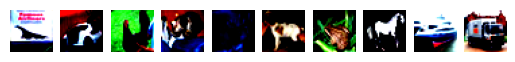

In [21]:
display_cifar(inversion_targets)

In [23]:
main_iters, input_iters, model_iters = 200, 20, 20
lambda_l2, lambda_tv = 0.1, 1.0

In [24]:
def launch_attack(inversion_targets, client, split_layer, clone_architecture="mlp",
                  main_iters=1000, input_iters=100, model_iters=100,
                  lambda_tv=0.1, lambda_l2=1, device="cuda:0"):
    clone = MLP() if architecture == "mlp" else CNN() if architecture == "cnn" else MLPMixerClient()
    mse = torch.nn.MSELoss()

    reconstructed_images, reconstruction_losses = [], []
    cut_layer_training_losses = []
    for idx, target in enumerate(inversion_targets):
        # obtain client output
        with torch.no_grad():
            client_out = client(target)

        # perform the attack
        target_size = target.size()
        reconstructed, cur_loss_arr = model_inversion_stealing(
            clone, split_layer, client_out, target_size,
            main_iters=main_iters, input_iters=input_iters, model_iters=model_iters,
            lambda_tv=lambda_tv, lambda_l2=lambda_l2, device=device
        )
        cut_layer_training_losses.append(cur_loss_arr)

        # save result
        reconstructed = normalize(reconstructed)
        reconstructed_images.append(reconstructed)
        reconstruction_loss = mse(reconstructed, target)
        reconstruction_losses.append(reconstruction_loss.item())
    return clone, reconstructed_images, reconstruction_losses, cut_layer_training_losses

In [32]:
clone, reconstructed_images, reconstruction_losses, cut_layer_training_losses = launch_attack(
    inversion_targets, client, split_layer, clone_architecture=MLPMixerClient,
    main_iters=main_iters, input_iters=input_iters, model_iters=model_iters,
    lambda_tv=lambda_tv, lambda_l2=lambda_l2, device=device
)

100%|██████████| 200/200 [00:19<00:00, 10.16it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

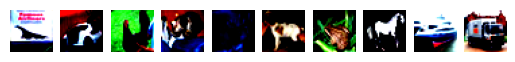

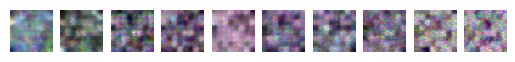

In [41]:
display_cifar(inversion_targets)
display_cifar(reconstructed_images)

In [36]:
compute_metrics(inversion_targets, reconstructed_images, reconstruction_losses, cut_layer_training_losses, compute_fid=True)

Recounstruction MSE: 1.439
Log10 of cut layer MSE: -5.494


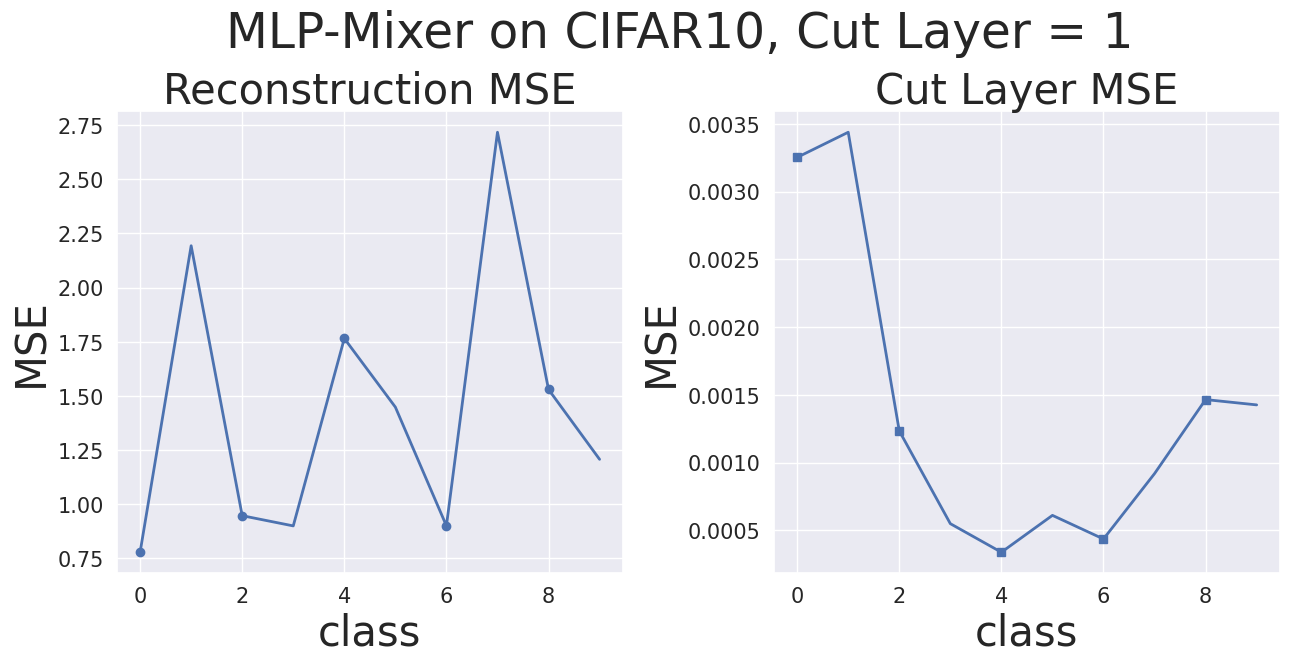

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
cut_layer_mse = np.mean(cut_layer_training_losses, axis=1)
markers = ['o','s']
titles = [f'Reconstruction MSE',
          f'Cut Layer MSE']
data = [reconstruction_losses, cut_layer_mse]

for i, axis in enumerate(ax):
    axis.plot(data[i], linewidth=2, marker=markers[i], markersize=6, markevery=2)
    axis.set_xlabel('class', fontsize=30)
    axis.set_ylabel('MSE', fontsize=30)
    axis.set_title(titles[i], fontsize=30)
    axis.grid(True)
    axis.tick_params(labelsize=15)

plt.subplots_adjust(wspace=0.3)
plt.suptitle('MLP-Mixer on CIFAR10, Cut Layer = {}'.format(split_layer), fontsize=35, y=1.05)
plt.show()